In [1]:
from backpack_predictor import prepare_data, target_encoding
from backpack_predictor.features import target, baseline_features, feature_list, cat_cols

%load_ext autoreload
%autoreload 2

from datetime import datetime
import time
import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer, TargetEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import root_mean_squared_error

import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

test_df = pd.read_csv(r'..//data//test.csv')
train_df = pd.read_csv(r'..//data//train.csv')
train_extra_df = pd.read_csv(r'..//data//training_extra.csv')
train_df = pd.concat([train_df, train_extra_df], ignore_index=True)

orig_df = pd.read_csv(r'..//data//orig.csv')
orig_df.insert(loc=0, column='id', value=0) # Add id to first col to match new train

# cat_features = []
# train_df[cat_features] = train_df[cat_features].astype('category')
# test_df[cat_features] = test_df[cat_features].astype('category')

train_df = prepare_data(train_df, is_train=True)
test_df = prepare_data(test_df, is_train=False)
orig_df = prepare_data(orig_df, is_train=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
orig_df.columns = [f"{c}_orig" for c in orig_df.columns]
orig_df_columns = orig_df.columns.to_list()

train_df = train_df.merge(orig_df.loc[(orig_df["weight_capacity_orig"]>5)&(orig_df["weight_capacity_orig"]<30)], left_on='weight_capacity', right_on='weight_capacity_orig', how='left')
test_df = test_df.merge(orig_df.loc[(orig_df["weight_capacity_orig"]>5)&(orig_df["weight_capacity_orig"]<30)], left_on='weight_capacity', right_on='weight_capacity_orig', how='left')

In [23]:
col1 = 'brand'
# col1 = 'weight_capacity'
# col2 = 'is_waterproof'
col2 = 'weight_capacity'
stats = ['mean', 'skew', 'var', 'count', 'min', 'max']

agg_stats = train_df.groupby(col1)[col2].agg(stats)
agg_stats

,mean,skew,var,count,min,max
brand,,,,,,
-1,17.738159,-0.091652,53.226821,126758,-1.0,30.0
0,18.035371,-0.068307,48.438474,797000,-1.0,30.0
1,17.948337,-0.051600,49.035789,755778,-1.0,30.0
2,18.006077,-0.060714,48.320308,764407,-1.0,30.0
3,18.017840,-0.072857,48.354067,749340,-1.0,30.0
4,18.041534,-0.071783,48.984312,801035,-1.0,30.0


In [ ]:
# import itertools

# best_pairs = ['material_is_waterproof', 'material_laptop_compartment', 'material_size', 'material_style', 'is_waterproof_color', 'style_color',]

# cols = ['brand', 'material', 'size', 'laptop_compartment', 'is_waterproof', 'style', 'color']
# for col1, col2 in itertools.combinations(cols, 2):
#     combined_col_name = f"{col1}_{col2}"

#     if combined_col_name not in best_pairs:
#         continue

#     train_df[combined_col_name] = (
#         train_df[col1].astype(str) + "_" + train_df[col2].astype(str)
#     )#.astype('category')

#     test_df[combined_col_name] = (
#         test_df[col1].astype(str) + "_" + test_df[col2].astype(str)
#     )#.astype('category')

# best_trios = ['material_laptop_compartment_is_waterproof', 'material_laptop_compartment_style', 'material_is_waterproof_style', 'material_size_laptop_compartment', 'laptop_compartment_is_waterproof_color']

# for col1, col2, col3 in itertools.combinations(cols, 3):
#     combined_col_name = f"{col1}_{col2}_{col3}"

#     if combined_col_name not in best_trios:
#         continue

#     train_df[combined_col_name] = (
#         train_df[col1].astype(str) + "_" +
#         train_df[col2].astype(str) + "_" +
#         train_df[col3].astype(str)
#     )

#     test_df[combined_col_name] = (
#         test_df[col1].astype(str) + "_" + 
#         test_df[col2].astype(str) + "_" +
#         test_df[col3].astype(str)
#     )

# best_quartet = ['material_size_laptop_compartment_is_waterproof', 'material_laptop_compartment_is_waterproof_style', 'brand_laptop_compartment_is_waterproof_style', 'material_laptop_compartment_is_waterproof_color', 'brand_material_laptop_compartment_is_waterproof']

# for col1, col2, col3, col4 in itertools.combinations(cols, 4):
#     combined_col_name = f"{col1}_{col2}_{col3}_{col4}"

#     if combined_col_name not in best_quartet:
#         continue

#     train_df[combined_col_name] = (
#         train_df[col1].astype(str) + "_" +
#         train_df[col2].astype(str) + "_" +
#         train_df[col3].astype(str) + "_" +
#         train_df[col4].astype(str)
#     )

#     test_df[combined_col_name] = (
#         test_df[col1].astype(str) + "_" + 
#         test_df[col2].astype(str) + "_" +
#         test_df[col3].astype(str) + "_" +
#         test_df[col4].astype(str)
#     )

In [13]:
import itertools

def create_comb_features(train_df, test_df, cols, allowed_features, comb_size):
    for comb in itertools.combinations(cols, comb_size):
        col_name = "_".join(comb)
        if col_name not in allowed_features:
            continue
        # Create the new feature by joining the selected columns row-wise
        train_df[col_name] = train_df[list(comb)].astype(str).agg('_'.join, axis=1)
        test_df[col_name] = test_df[list(comb)].astype(str).agg('_'.join, axis=1)


best_2 = [
    'material_is_waterproof', 'material_laptop_compartment',
    'material_size', 'material_style', 'is_waterproof_color', 'style_color'
]
best_3 = [
    'material_laptop_compartment_is_waterproof', 'material_laptop_compartment_style',
    'material_is_waterproof_style', 'material_size_laptop_compartment', 'laptop_compartment_is_waterproof_color'
]
best_4 = [
    'material_size_laptop_compartment_is_waterproof', 'material_laptop_compartment_is_waterproof_style',
    'brand_laptop_compartment_is_waterproof_style', 'material_laptop_compartment_is_waterproof_color',
    'brand_material_laptop_compartment_is_waterproof'
]

cols = ['brand', 'material', 'size', 'laptop_compartment', 'is_waterproof', 'style', 'color']
create_comb_features(train_df, test_df, cols, best_2, 2)
create_comb_features(train_df, test_df, cols, best_3, 3)
create_comb_features(train_df, test_df, cols, best_4, 4)

In [34]:
train_df

,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,price,...,compartments_orig,laptop_compartment_orig,is_waterproof_orig,style_orig,color_orig,weight_capacity_orig,price_orig,cluster,cluster_5000,cluster_50000
0,3,0,1,7,1,0,2,0,11.611723,112.15875,...,7.0,0.0,1.0,2.0,0.0,11.611723,39.770555,3381,2662,30077
1,3,3,0,10,1,1,1,4,27.078537,68.88056,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1948,2741,39698
2,4,0,0,2,1,0,1,2,16.643760,39.17320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1563,3842,24843
3,2,1,0,8,1,0,1,4,12.937220,80.60793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,987,3118,24040
4,0,3,1,1,1,1,1,4,17.749338,86.02312,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119,810,23850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3994313,2,3,-1,3,1,1,1,5,28.098120,104.74460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1229,3204,12167
3994314,1,0,0,10,1,1,2,5,17.379531,122.39043,...,7.0,-1.0,0.0,2.0,5.0,17.379531,74.027653,4645,4701,21764
3994315,3,3,2,10,0,0,0,2,17.037708,148.18470,...,10.0,1.0,1.0,0.0,1.0,17.037708,150.000000,1618,4230,38968
3994316,1,3,-1,2,0,0,0,1,28.783339,22.32269,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1156,2183,12925


In [ ]:
import time
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.cluster import MiniBatchKMeans

# Define columns for preprocessing
numeric_cols = ['weight_capacity', 'laptop_compartment', 'is_waterproof', 'size', 'compartments', 'brand', 'material', 'size', 'style', 'color']
cat_cols = []

# Create pipelines for numeric and categorical features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop=None))])

# Build a preprocessor to transform the selected columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop'  # drop any columns not specified
)

# List of cluster sizes
n_clusters_list = [5000, 50000, 500000, 1000000]

# Loop through each cluster size, fit on combined data, then split the results
for n in n_clusters_list:
    print(f"Processing MiniBatchKMeans with {n} clusters on combined train and test data")
    model_start_time = time.time()
    
    # Build a pipeline with preprocessing and clustering
    kmeans_pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('clusterer', MiniBatchKMeans(n_clusters=n, random_state=42, max_no_improvement=2, tol=0.01, batch_size=256*20))
    ])
    
    # Combine train and test data (resetting index ensures proper alignment later)
    combined_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    
    # Fit the pipeline on the combined data and get cluster labels
    combined_labels = kmeans_pipeline.fit_predict(combined_df)
    
    # Split the labels back into train and test sets
    n_train = train_df.shape[0]
    train_labels = combined_labels[:n_train]
    test_labels = combined_labels[n_train:]
    
    # Save cluster labels in new columns for both dataframes
    train_df[f'cluster_{n}'] = train_labels
    test_df[f'cluster_{n}'] = test_labels
    
    print(f"MiniBatchKMeans with n_clusters={n} completed in {time.time() - model_start_time:.2f} seconds")
    # print("Cluster counts on training data:")
    # print(pd.Series(train_labels).value_counts().reset_index())


# MiniBatchKMeans with n_clusters=5000 completed in 95.50 seconds
# MiniBatchKMeans with n_clusters=50000 completed in 1432.59 seconds

Processing MiniBatchKMeans with 5000 clusters on combined train and test data
MiniBatchKMeans with n_clusters=5000 completed in 24.29 seconds
Processing MiniBatchKMeans with 50000 clusters on combined train and test data


In [ ]:
cluster_cols = [f'cluster_{n}' for n in n_clusters_list]
cluster_cols

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.cluster import MiniBatchKMeans

numeric_cols = ['weight_capacity']
cat_cols = ['compartments', 'laptop_compartment', 'is_waterproof', 'brand', 'material', 'size', 'style', 'color']

numeric_transformer = Pipeline(
    steps=[('scaler', StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop=None))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop'  # drop other columns not listed
)

### MiniBatchKMeans
model_start_time = time.time()
kmeans_pipeline = Pipeline(
    steps=[
        ('preprocessing', preprocessor),
        ('clusterer', MiniBatchKMeans(n_clusters=5000, random_state=42))
    ]
)

kmeans_pipeline.fit(train_df)
kmeans_labels = kmeans_pipeline.named_steps['clusterer'].labels_
train_df['cluster'] = kmeans_labels
print(f"MiniBatchKMeans Training & Prediction time: {time.time() - model_start_time:.2f} seconds")

print("MiniBatchKMeans cluster counts:")
display(pd.Series(kmeans_labels).value_counts().reset_index())

MiniBatchKMeans Training & Prediction time: 95.27 seconds
MiniBatchKMeans cluster counts:


,index,count
0,4019,2368
1,3185,2306
2,4320,2222
3,643,2204
4,3440,2188
...,...,...
4995,3574,172
4996,3987,172
4997,28,171
4998,1940,167


In [ ]:
# %%time

lgb_params_1 = {'force_col_wise': True, 'objective': 'regression', 'metric': 'rmse', 'verbose': -1, 'early_stopping_rounds': 916, 'cat_l2': 40.57932515907615, 'extra_trees': False, 'feature_fraction': 0.9028265875188044, 'learning_rate': 0.02133798565133846, 'max_bin': 7449, 'max_depth': 590, 'min_samples_leaf': 22, 'n_estimators': 14706, 'num_leaves': 141, 'lambda_l1': 0.004931837373939155, 'lambda_l2': 2.1647829905701264e-06}

stats = ['mean', 'skew', 'count', 'var']
outer_folds = 5
inner_folds = 20

# Target sets use the target variable, and must be trained on the inner CV loop.
target_feature_cols = []
# target_feature_cols = ['weight_capacity', 'compartments', 'wc_decimal_count', 'brand', 'color', 'laptop_compartment', 'is_waterproof', 'size', 'material', 'style']
# target_feature_cols = ['weight_capacity', 'compartments', 'price_orig']
# target_feature_cols = ['weight_capacity', 'compartments']#, 'price_orig']
target_feature_cols = ['weight_capacity', 'compartments', 'laptop_compartment', 'is_waterproof', 'material', 'brand', 'color', 'size', 'style']
target_feature_cols = target_feature_cols + orig_df_columns + cluster_cols # best_2 + best_3 + best_4 
target_feature_sets = {
    f"{col1}": {
        "stats": stats
    }
    for col1 in target_feature_cols
}

all_new_cols = []
for col1, v in target_feature_sets.items():
    new_cols = [f"{col1}_{target}_{stat}" for stat in stats]
    target_feature_sets[col1]['new_cols'] = new_cols
    all_new_cols.extend(new_cols)

feature_sets = {}
additional_features = ['compartments', 'is_waterproof', 'laptop_compartment', 'style', 'material', 'size', 'brand', 'color']
for col1 in additional_features:
    feature_sets[col1] = {
        'col2_list': ['weight_capacity'],
        'stats': stats,
}

for col1, v in feature_sets.items():
    col2_list = v['col2_list']
    new_cols = [f"{col1}_{col2}_{stat}" for col2 in col2_list for stat in stats]
    feature_sets[col1]['new_cols'] = new_cols
    all_new_cols.extend(new_cols)

features = ['weight_capacity', 'compartments', 'laptop_compartment', 'is_waterproof', 'material', 'brand', 'color', 'size', 'style'] 
features = ['weight_capacity', 'compartments', 'laptop_compartment', 'is_waterproof'] 
features = features + all_new_cols + orig_df_columns + best_2 + best_3 + best_4 + cluster_cols
print(f"Using {len(features)} features.")

# Prepare arrays for out-of-fold and test predictions
oof = np.zeros(len(train_df), dtype=float)
pred = np.zeros(len(test_df), dtype=float)

rmse_list = []

kf = KFold(n_splits=outer_folds, shuffle=True, random_state=42)
for i, (train_idx, valid_idx) in enumerate(kf.split(train_df), 1):
    train_fold = train_df.loc[train_idx].reset_index(drop=True)
    valid_fold = train_df.loc[valid_idx].reset_index(drop=True)

    # -----------------------------------------------------
    # Inner K-Fold (for partial target encoding)
    # -----------------------------------------------------
    kf_inner = KFold(n_splits=inner_folds, shuffle=True, random_state=42)
    for j, (inner_train_idx, inner_valid_idx) in enumerate(kf_inner.split(train_fold)):
        inner_train = train_fold.loc[inner_train_idx].copy()
        for col1, v in target_feature_sets.items():
            stats = v['stats']
            new_cols = v['new_cols']
            agg_stats = inner_train.groupby(col1)[target].agg(stats)
            for stat, new_col in zip(stats, new_cols):
                train_fold.loc[inner_valid_idx, new_col] = train_fold.loc[inner_valid_idx, col1].map(agg_stats[stat])

    # -----------------------------------------------------
    # Outer K-Fold Add Feature Sets
    # -----------------------------------------------------
    for col1, v in target_feature_sets.items():
        stats = v['stats']
        new_cols = v['new_cols']
        agg_stats = train_fold.groupby(col1)[target].agg(stats)
        for stat, new_col in zip(stats, new_cols):
            valid_fold.loc[:, new_col] = valid_fold.loc[:, col1].map(agg_stats[stat])
            test_df.loc[:, new_col] = test_df.loc[:, col1].map(agg_stats[stat])

    for col1, v in feature_sets.items():
        stats = v['stats']
        col2_list = v['col2_list']
        new_cols = v['new_cols']
        for k, col2 in enumerate(col2_list):
            agg_stats = train_fold.groupby(col1)[col2].agg(stats)
            for stat, new_col in zip(stats, new_cols[k*len(stats):(k+1)*len(stats)]):
                train_fold.loc[:, new_col] = train_fold.loc[:, col1].map(agg_stats[stat])
                valid_fold.loc[:, new_col] = valid_fold.loc[:, col1].map(agg_stats[stat])
                test_df.loc[:, new_col] = test_df.loc[:, col1].map(agg_stats[stat])

    # -----------------------------------------------------
    # Modeling
    # -----------------------------------------------------
    train_data = lgb.Dataset(train_fold[features], label=train_fold[target])
    valid_data = lgb.Dataset(valid_fold[features], label=valid_fold[target], reference=train_data)
    
    model = lgb.train(
        params=lgb_params_1,
        train_set=train_data,
        valid_sets=[train_data, valid_data],
        valid_names=['train', 'valid'],
    )
    y_pred = model.predict(valid_fold[features], num_iteration=model.best_iteration)
    
    rmse = root_mean_squared_error(valid_fold[target], y_pred)
    rmse_list.append(rmse)
    print(f"[{i}] RMSE: {rmse:.2f}, AVG: {np.mean(rmse_list):.2f}")

    oof[valid_idx] = y_pred
    pred += model.predict(test_df[features], num_iteration=model.best_iteration)

print(f"Mean RMSE: {np.mean(rmse_list):.2f}")

Using 181 features.
[1] RMSE: 38.69, AVG: 38.69
[2] RMSE: 38.73, AVG: 38.71
Mean RMSE: 38.71


In [ ]:
# %%time

lgb_params_1 = {'force_col_wise': True, 'objective': 'regression', 'metric': 'rmse', 'verbose': -1, 'early_stopping_rounds': 916, 'cat_l2': 40.57932515907615, 'extra_trees': False, 'feature_fraction': 0.9028265875188044, 'learning_rate': 0.02133798565133846, 'max_bin': 7449, 'max_depth': 590, 'min_samples_leaf': 22, 'n_estimators': 14706, 'num_leaves': 141, 'lambda_l1': 0.004931837373939155, 'lambda_l2': 2.1647829905701264e-06}

stats = ['mean', 'skew', 'count', 'var']
outer_folds = 50
inner_folds = 20

# Target sets use the target variable, and must be trained on the inner CV loop.
target_feature_cols = []
# target_feature_cols = ['weight_capacity', 'compartments', 'wc_decimal_count', 'brand', 'color', 'laptop_compartment', 'is_waterproof', 'size', 'material', 'style']
# target_feature_cols = ['weight_capacity', 'compartments', 'price_orig']
# target_feature_cols = ['weight_capacity', 'compartments']#, 'price_orig']
target_feature_cols = ['weight_capacity', 'compartments'] + orig_df_columns + ['laptop_compartment', 'is_waterproof', 'material', 'brand', 'color', 'size', 'style']
target_feature_cols = target_feature_cols + best_2 + best_3 + best_4 
target_feature_sets = {
    f"{col1}": {
        "stats": stats
    }
    for col1 in target_feature_cols
}

all_new_cols = []
for col1, v in target_feature_sets.items():
    new_cols = [f"{col1}_{target}_{stat}" for stat in stats]
    target_feature_sets[col1]['new_cols'] = new_cols
    all_new_cols.extend(new_cols)

feature_sets = {
    'compartments': {
        'col2_list': ['weight_capacity'],
        'stats': stats,
    },
    'is_waterproof': {
        'col2_list': ['weight_capacity'],
        'stats': stats,
    },
    'laptop_compartment': {
        'col2_list': ['weight_capacity'],
        'stats': stats,
    },
    'style': {
        'col2_list': ['weight_capacity'],
        'stats': stats,
    },
    'size': {
        'col2_list': ['weight_capacity'],
        'stats': stats,
    },
    # 'material': {
    #     'col2_list': ['is_waterproof', 'laptop_compartment', 'style', 'size'],
    #     'stats': stats,
    # },
}
for col1, v in feature_sets.items():
    col2_list = v['col2_list']
    new_cols = [f"{col1}_{col2}_{stat}" for col2 in col2_list for stat in stats]
    feature_sets[col1]['new_cols'] = new_cols
    all_new_cols.extend(new_cols)

# features = ['weight_capacity', 'compartments', 'laptop_compartment', 'is_waterproof', 'brand', 'color', 'size', 'material', 'style' ] 
features = ['weight_capacity', 'compartments', 'laptop_compartment', 'is_waterproof', 'brand', 'color', 'size', 'material', 'style'] 
features = features + all_new_cols #+ orig_df_columns

print(f"Using {len(features)} features.")


# Prepare arrays for out-of-fold and test predictions
oof = np.zeros(len(train_df), dtype=float)
pred = np.zeros(len(test_df), dtype=float)

rmse_list = []

kf = KFold(n_splits=outer_folds, shuffle=True, random_state=42)
for i, (train_idx, valid_idx) in enumerate(kf.split(train_df), 1):
    train_fold = train_df.loc[train_idx].reset_index(drop=True)
    valid_fold = train_df.loc[valid_idx].reset_index(drop=True)

    # -----------------------------------------------------
    # Inner K-Fold (for partial target encoding)
    # -----------------------------------------------------
    kf_inner = KFold(n_splits=inner_folds, shuffle=True, random_state=42)
    for j, (inner_train_idx, inner_valid_idx) in enumerate(kf_inner.split(train_fold)):
        inner_train = train_fold.loc[inner_train_idx].copy()
        for col1, v in target_feature_sets.items():
            stats = v['stats']
            new_cols = v['new_cols']
            agg_stats = inner_train.groupby(col1)[target].agg(stats)
            for stat, new_col in zip(stats, new_cols):
                train_fold.loc[inner_valid_idx, new_col] = train_fold.loc[inner_valid_idx, col1].map(agg_stats[stat])

    # -----------------------------------------------------
    # Outer K-Fold Add Feature Sets
    # -----------------------------------------------------
    for col1, v in target_feature_sets.items():
        stats = v['stats']
        new_cols = v['new_cols']
        agg_stats = train_fold.groupby(col1)[target].agg(stats)
        for stat, new_col in zip(stats, new_cols):
            valid_fold.loc[:, new_col] = valid_fold.loc[:, col1].map(agg_stats[stat])
            test_df.loc[:, new_col] = test_df.loc[:, col1].map(agg_stats[stat])

    for col1, v in feature_sets.items():
        stats = v['stats']
        col2_list = v['col2_list']
        new_cols = v['new_cols']
        for k, col2 in enumerate(col2_list):
            agg_stats = train_fold.groupby(col1)[col2].agg(stats)
            for stat, new_col in zip(stats, new_cols[k*len(stats):(k+1)*len(stats)]):
                train_fold.loc[:, new_col] = train_fold.loc[:, col1].map(agg_stats[stat])
                valid_fold.loc[:, new_col] = valid_fold.loc[:, col1].map(agg_stats[stat])
                test_df.loc[:, new_col] = test_df.loc[:, col1].map(agg_stats[stat])

    # -----------------------------------------------------
    # Modeling
    # -----------------------------------------------------
    train_data = lgb.Dataset(train_fold[features], label=train_fold[target])
    valid_data = lgb.Dataset(valid_fold[features], label=valid_fold[target], reference=train_data)
    
    model = lgb.train(
        params=lgb_params_1,
        train_set=train_data,
        valid_sets=[train_data, valid_data],
        valid_names=['train', 'valid'],
    )
    y_pred = model.predict(valid_fold[features], num_iteration=model.best_iteration)
    
    rmse = root_mean_squared_error(valid_fold[target], y_pred)
    rmse_list.append(rmse)
    print(f"[{i}] RMSE: {rmse:.2f}, AVG: {np.mean(rmse_list):.2f}")

    oof[valid_idx] = y_pred
    pred += model.predict(test_df[features], num_iteration=model.best_iteration)

print(f"Mean RMSE: {np.mean(rmse_list):.2f}")

Using 169 features.
[1] RMSE: 38.72, AVG: 38.72
[2] RMSE: 38.55, AVG: 38.63
[3] RMSE: 38.64, AVG: 38.64
[4] RMSE: 38.69, AVG: 38.65
[5] RMSE: 38.62, AVG: 38.64
[6] RMSE: 38.60, AVG: 38.64
[7] RMSE: 38.51, AVG: 38.62
[8] RMSE: 38.74, AVG: 38.63
[9] RMSE: 38.62, AVG: 38.63
[10] RMSE: 38.58, AVG: 38.63
[11] RMSE: 38.56, AVG: 38.62
[12] RMSE: 38.57, AVG: 38.62
[13] RMSE: 38.63, AVG: 38.62
[14] RMSE: 38.62, AVG: 38.62
[15] RMSE: 38.70, AVG: 38.62
[16] RMSE: 38.67, AVG: 38.63
[17] RMSE: 38.66, AVG: 38.63
[18] RMSE: 38.58, AVG: 38.63
[19] RMSE: 38.54, AVG: 38.62
[20] RMSE: 38.62, AVG: 38.62
[21] RMSE: 38.71, AVG: 38.63
[22] RMSE: 38.57, AVG: 38.62
[23] RMSE: 38.64, AVG: 38.62
[24] RMSE: 38.67, AVG: 38.63
[25] RMSE: 38.60, AVG: 38.62
[26] RMSE: 38.73, AVG: 38.63
[27] RMSE: 38.74, AVG: 38.63
[28] RMSE: 38.67, AVG: 38.63
[29] RMSE: 38.75, AVG: 38.64
[30] RMSE: 38.78, AVG: 38.64
[31] RMSE: 38.66, AVG: 38.64
[32] RMSE: 38.68, AVG: 38.64
[33] RMSE: 38.61, AVG: 38.64
[34] RMSE: 38.68, AVG: 38.64
[35

In [ ]:
Using 169 features.
[1] RMSE: 38.64, AVG: 38.64
[2] RMSE: 38.64, AVG: 38.64
[3] RMSE: 38.71, AVG: 38.66
[4] RMSE: 38.65, AVG: 38.66
[5] RMSE: 38.69, AVG: 38.67
Mean RMSE: 38.67

In [144]:
lgb_params_1['verbose'] = 1

model = lgb.train(
    params=lgb_params_1,
    train_set=train_data,
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'valid'],
)

[LightGBM] [Info] Total Bins 145803
[LightGBM] [Info] Number of data points in the train set: 3195455, number of used features: 41
[LightGBM] [Info] Start training from score 81.360364
Training until validation scores don't improve for 916 rounds
Early stopping, best iteration is:
[586]	train's rmse: 38.4031	valid's rmse: 38.6926


In [ ]:
root_mean_squared_error(valid_fold[target], y_pred)

38.723439133339085

In [133]:
train_fold[features]

,weight_capacity,compartments,laptop_compartment,is_waterproof,brand,color,size,material,style,weight_capacity_compartments_mean,...,weight_capacity_laptop_compartment_count,weight_capacity_laptop_compartment_var,weight_capacity_style_mean,weight_capacity_style_skew,weight_capacity_style_count,weight_capacity_style_var,weight_capacity_size_mean,weight_capacity_size_skew,weight_capacity_size_count,weight_capacity_size_var
0,11.611723,7,1,0,3,0,1,0,2,5.562500,...,64.0,0.285466,1.171875,-0.584188,64.0,0.906498,0.937500,0.104211,64.0,0.567460
1,27.078537,10,1,1,3,4,0,3,1,10.000000,...,1.0,NaN,1.000000,NaN,1.0,NaN,0.000000,NaN,1.0,NaN
2,16.643760,2,1,0,4,2,0,0,1,2.000000,...,1.0,NaN,1.000000,NaN,1.0,NaN,0.000000,NaN,1.0,NaN
3,12.937220,8,1,0,2,4,0,1,1,8.000000,...,1.0,NaN,1.000000,NaN,1.0,NaN,0.000000,NaN,1.0,NaN
4,7.241812,10,0,1,2,0,1,3,-1,5.093750,...,64.0,0.317460,0.796875,0.169385,64.0,0.608879,0.796875,0.005138,64.0,0.799355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195450,16.641739,6,1,1,3,2,2,2,0,6.000000,...,1.0,NaN,0.000000,NaN,1.0,NaN,2.000000,NaN,1.0,NaN
3195451,28.098120,3,1,1,2,5,-1,3,1,6.333333,...,3.0,0.333333,0.666667,-1.732051,3.0,0.333333,0.333333,0.935220,3.0,2.333333
3195452,17.037708,10,0,0,3,2,2,3,0,6.022989,...,87.0,0.275327,1.206897,-0.528011,87.0,0.747394,1.034483,-0.372994,87.0,0.591820
3195453,28.783339,2,0,0,1,1,-1,3,0,5.150000,...,40.0,0.225000,0.925000,-0.106842,40.0,0.737821,0.975000,-0.365431,40.0,0.845513


In [ ]:
# Using 29 features.
# [1] RMSE: 38.67, AVG: 38.67
# [2] RMSE: 38.66, AVG: 38.67
# [3] RMSE: 38.73, AVG: 38.69
# [4] RMSE: 38.68, AVG: 38.69
# [5] RMSE: 38.72, AVG: 38.70
# Mean RMSE: 38.70

# Using 9 features.
# [1] RMSE: 38.82, AVG: 38.82
# [2] RMSE: 38.81, AVG: 38.82
# [3] RMSE: 38.88, AVG: 38.84
# [4] RMSE: 38.83, AVG: 38.84
# [5] RMSE: 38.88, AVG: 38.84
# Mean RMSE: 38.84

# Using 37 features.
# [3] RMSE: 38.65, AVG: 38.65
# [3] RMSE: 38.61, AVG: 38.63
# [3] RMSE: 38.62, AVG: 38.63
# [3] RMSE: 38.63, AVG: 38.63
# [3] RMSE: 38.65, AVG: 38.63
# [3] RMSE: 38.74, AVG: 38.65
# [3] RMSE: 38.66, AVG: 38.65
# [3] RMSE: 38.62, AVG: 38.65
# [3] RMSE: 38.66, AVG: 38.65
# [3] RMSE: 38.70, AVG: 38.66
# Mean RMSE: 38.66

3

Using 37 features.
[3] RMSE: 38.65, AVG: 38.65
[3] RMSE: 38.61, AVG: 38.63
[3] RMSE: 38.62, AVG: 38.63
[3] RMSE: 38.63, AVG: 38.63
[3] RMSE: 38.65, AVG: 38.63
[3] RMSE: 38.74, AVG: 38.65
[3] RMSE: 38.66, AVG: 38.65
[3] RMSE: 38.62, AVG: 38.65
[3] RMSE: 38.66, AVG: 38.65
[3] RMSE: 38.70, AVG: 38.66
Mean RMSE: 38.66

In [25]:
submit_df = test_df[['id']].copy()
submit_df['Price'] = (pred / outer_folds)
submit_path = f'..//submissions//' + datetime.now().strftime("%Y-%m-%d_%H-%M") + ".csv"
submit_df.to_csv(submit_path, index=False)
print("Saved to:", submit_path)
submit_df.head(5)

Saved to: ..//submissions//2025-02-26_07-03.csv


,id,Price
0,300000,81.126184
1,300001,83.119731
2,300002,88.608532
3,300003,77.233329
4,300004,79.403229


* Mean RMSE: 38.66

* Mean RMSE: 38.84



CHANGE VERSION

In [ ]:
# OOF_VERSION = '2025-02-26_07-03'
# oof_path = f"..//data//oof_v{OOF_VERSION}.csv"
# pd.DataFrame(oof).to_csv(oof_path, header=False, index=False)
# print("Saving to:", oof_path)

Saving to: ..//data//oof_v2025-02-26_07-03.csv


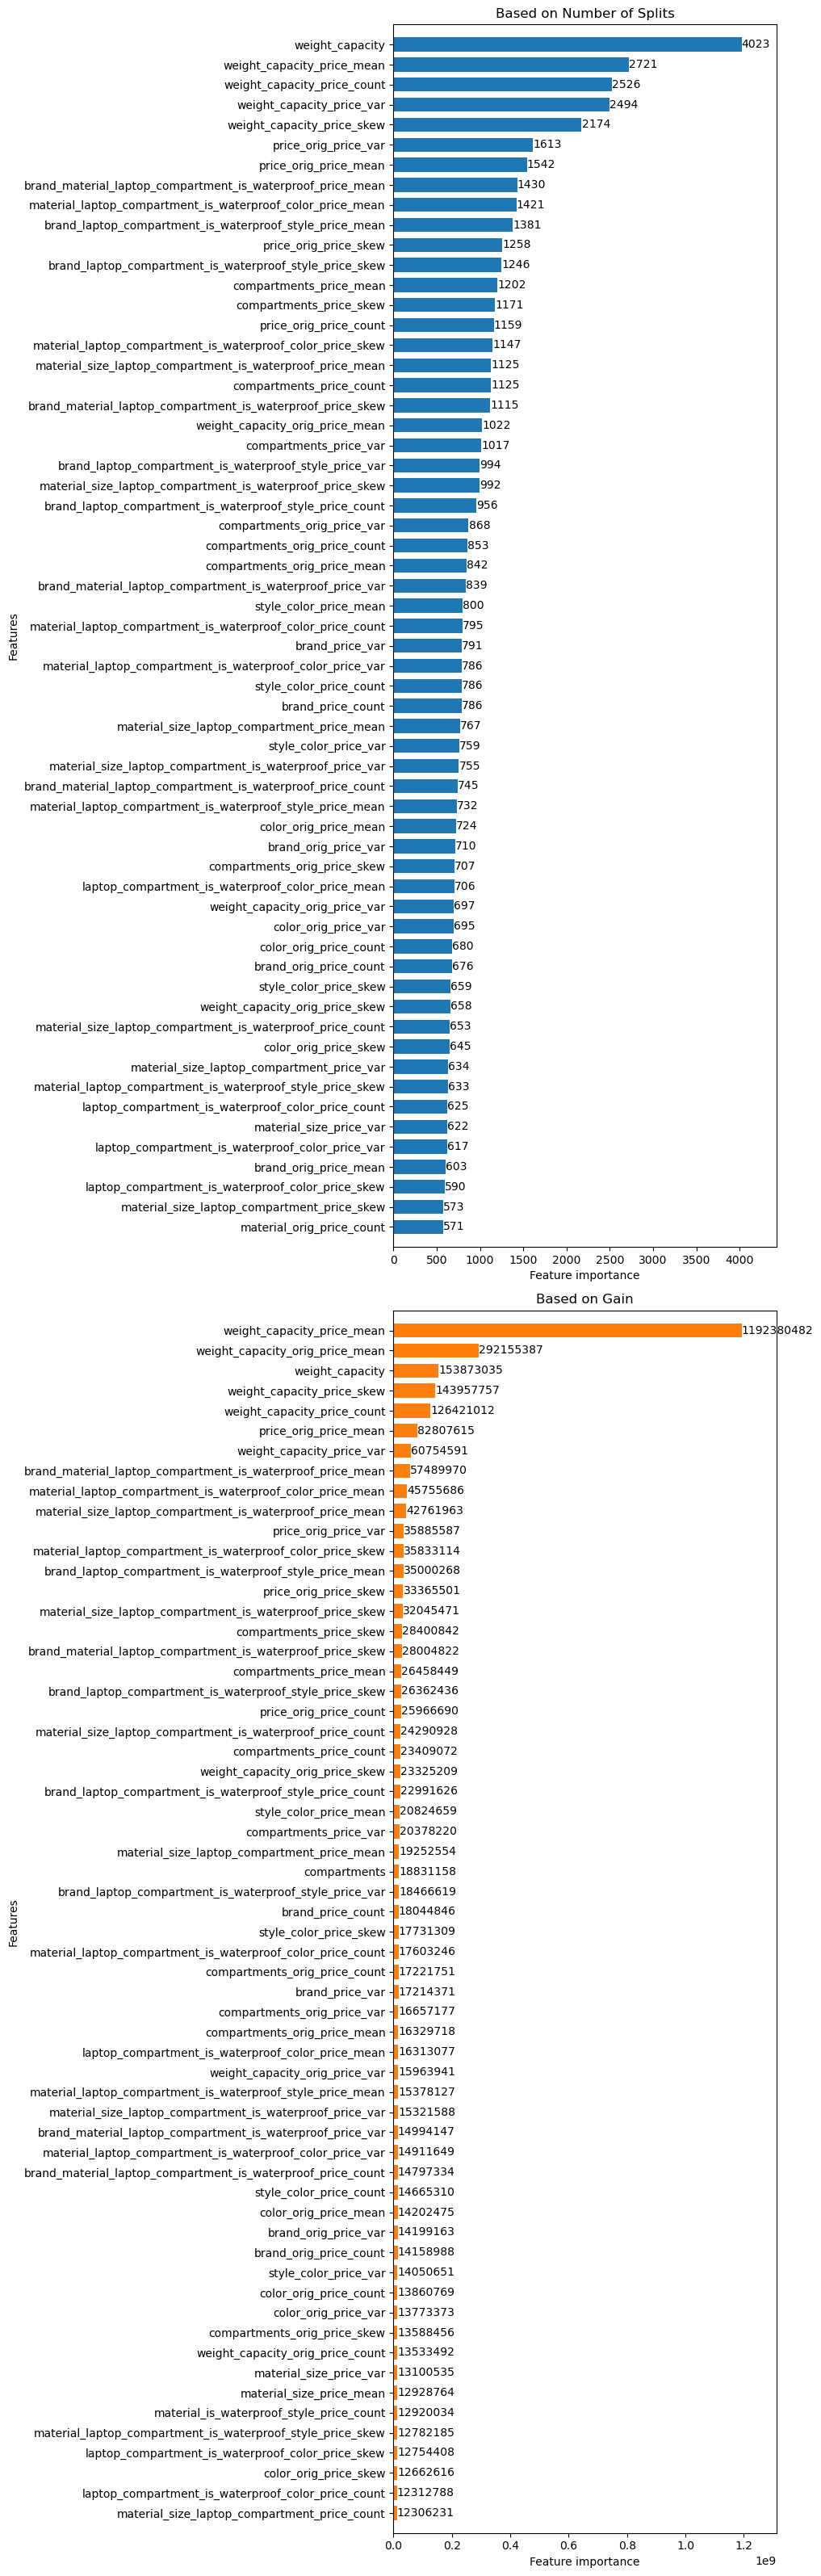

In [28]:
fig, axs = plt.subplots(2, 1, figsize=(10, 32))

lgb.plot_importance(model, ax=axs[0], importance_type='split', max_num_features=60, 
                    height=0.7, grid=False, precision=0, color="tab:blue")
axs[0].set_title("Based on Number of Splits", fontsize=12)

lgb.plot_importance(model, ax=axs[1], importance_type='gain', max_num_features=60, 
                    height=0.7, grid=False, precision=0, color="tab:orange")
axs[1].set_title("Based on Gain", fontsize=12)

plt.tight_layout()
plt.show()

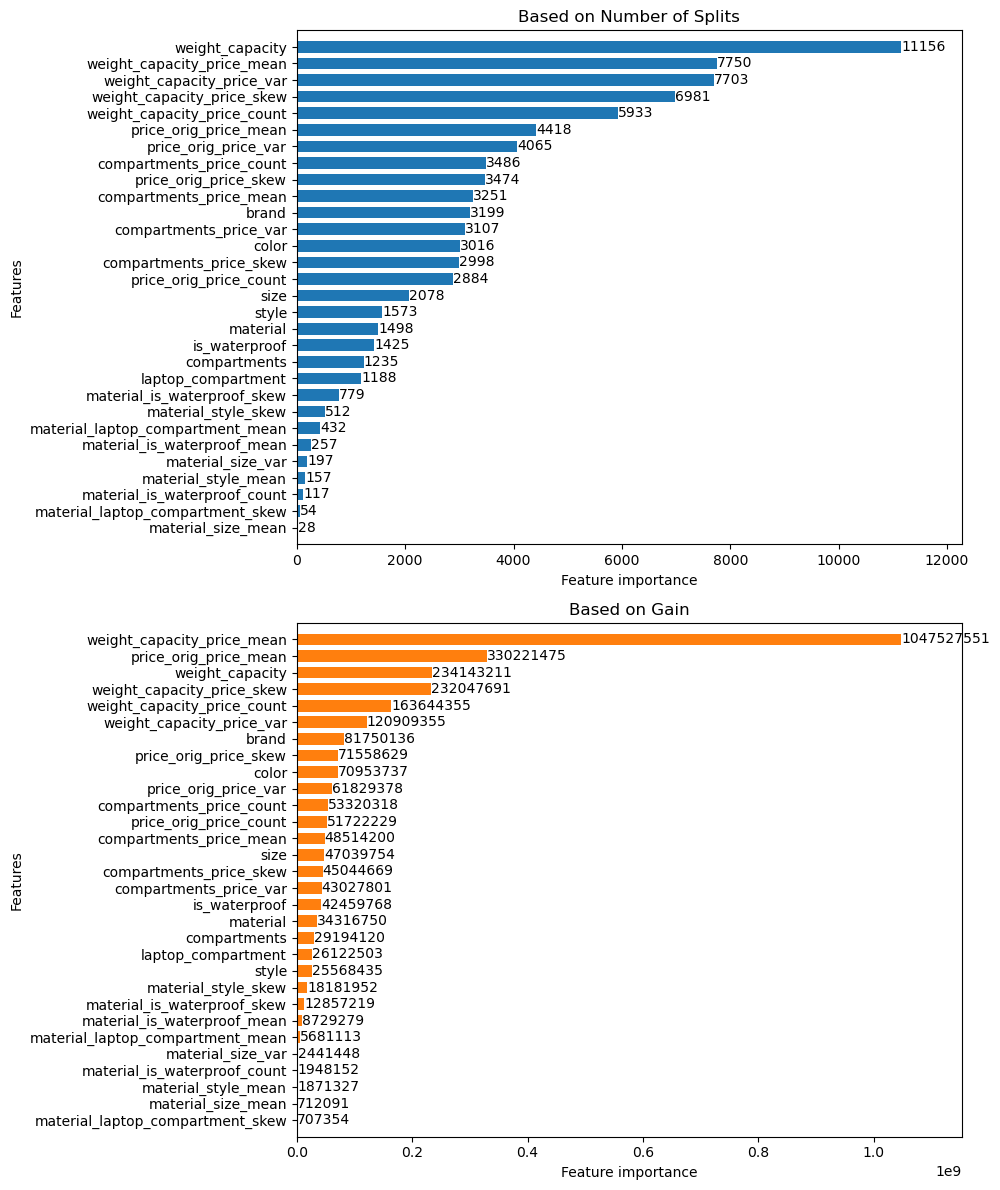

In [93]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

lgb.plot_importance(model, ax=axs[0], importance_type='split', max_num_features=30, 
                    height=0.7, grid=False, precision=0, color="tab:blue")
axs[0].set_title("Based on Number of Splits", fontsize=12)

lgb.plot_importance(model, ax=axs[1], importance_type='gain', max_num_features=30, 
                    height=0.7, grid=False, precision=0, color="tab:orange")
axs[1].set_title("Based on Gain", fontsize=12)

plt.tight_layout()
plt.show()

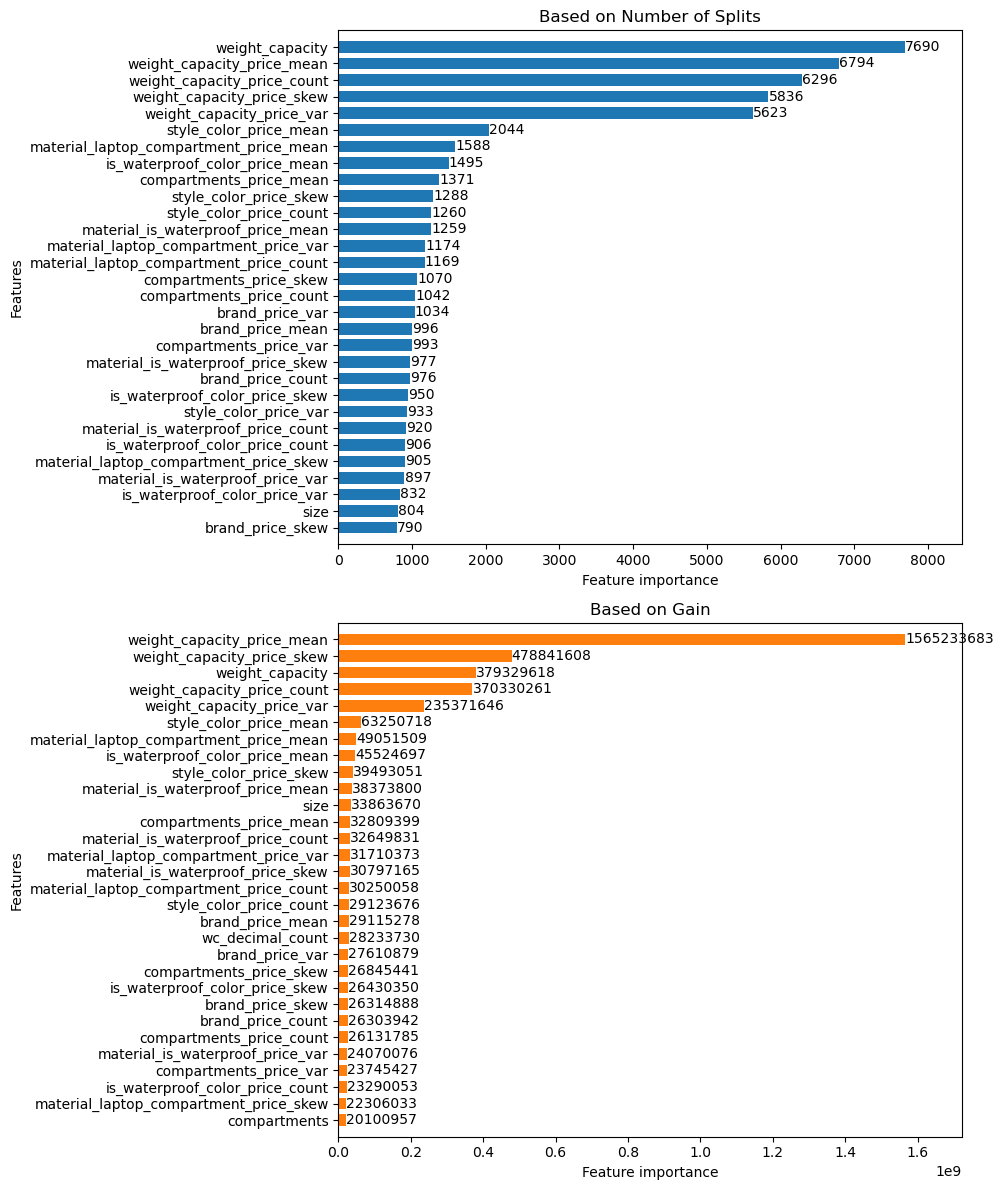

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

lgb.plot_importance(model, ax=axs[0], importance_type='split', max_num_features=30, 
                    height=0.7, grid=False, precision=0, color="tab:blue")
axs[0].set_title("Based on Number of Splits", fontsize=12)

lgb.plot_importance(model, ax=axs[1], importance_type='gain', max_num_features=30, 
                    height=0.7, grid=False, precision=0, color="tab:orange")
axs[1].set_title("Based on Gain", fontsize=12)

plt.tight_layout()
plt.show()